# Lab 4: Parte 2 - Optimización multiobjetivo en problemas no lineales

In [52]:
import matplotlib.pyplot as plt
import math
from pyomo.environ import *
from pyomo.opt import SolverFactory
opt = SolverFactory('ipopt')
import pandas as pd
import numpy as np

## Pregunta 1: Beneficio vs Unidades Vendidas

Una startup necesita aumentar las ventas de un producto a través de publicidad. Si la empresa gasta $a$ (medido en miles de dólares) en publicidad y cobra un precio de $p=10+0.38a$ dólares por unidad, entonces puede vender $1000-10p+20\sqrt{a}$ unidades del producto. El costo de producción por unidad del producto es $6$. Ayuda a la empresa a encontrar al menos 10 soluciones de Pareto óptimas y traza la frontera de Pareto entre los objetivos de maximizar el beneficio y maximizar el número de unidades vendidas.

### Parte I: Formulación del modelo matemático

Formula el problema matemático listando:
- Variables de decisión
- Función objetivo
- Restricciones

1. Variables de Decisión  
  - $ a = $ inversión en publicidad (miles de dólares)

2. Función Objetivo  
  - $Max :\ ventas\ unitarias(a) = f_1(a) $  
    - $ventas\ unitarias(a) = 1000-10p+20\sqrt{a}$  
    - Sustituyendo:  
      - $ ventas\ unitarias(a) = 1000-10(10+0.38a)+20\sqrt{a} $  
      - $ ventas\ unitarias(a) = 890-3.8a+20\sqrt{a} $  
    - $ Max :\ ventas\ unitarias(a) = f_1(a) = 890-3.8a+20\sqrt{a} $
    
  - $Max :\ beneficio(a) = f_2(a) $  
    - $ beneficio = ventas\ unitarias * margen - inversión$
    - $ beneficio = ventas\ unitarias * (precio - 6) - a $
    - Sustituyendo:  
      - $ beneficio(a) = ventas\ unitarias * ((10+0.38a) - 6) - a $
      - $ beneficio(a) = (890-3.8a+20\sqrt{a}) * (4+0.38a) - a $
    - $Max :\ beneficio(a) = f_2(a) = -1.444a^2 + 7.6\sqrt{a}*a + 80\sqrt{a} + 322a +3560 $

3. Restricciones  
  - $ a > 0 $

In [53]:
def delete_component(Model, comp_name):
    list_del = [vr for vr in vars(Model)
                if comp_name == vr
                or vr.startswith(comp_name + '_index')
                or vr.startswith(comp_name + '_domain')]
    for kk in list_del:
        Model.del_component(kk)

model = ConcreteModel()

model.a = Var(domain=NonNegativeReals)

epsilon = 1e-6

def ventas_unitarias(model):
    return 890 - 3.8 * model.a + 20 * ((model.a + epsilon) ** 0.5)

def beneficio(model):
    return -1.444 * model.a**2 + 7.6 * (model.a + epsilon)**0.5 * model.a + 80 * (model.a + epsilon)**0.5 + 322 * model.a + 3560

soluciones_a = []
soluciones_ventas = []
soluciones_beneficio = []

model.objetivo = Objective(expr=ventas_unitarias(model), sense=maximize)
opt.solve(model, tee=False)
ventas_max = value(ventas_unitarias(model))

epsilons = np.linspace(ventas_max * 0.5, ventas_max, 18)

for eps in epsilons:
    model.objetivo = Objective(expr=beneficio(model), sense=maximize)
    model.ventas_constraint = Constraint(expr=ventas_unitarias(model) >= eps)

    result = opt.solve(model, tee=False)
    a_opt = value(model.a)

    ventas_opt = ventas_unitarias(model)()
    beneficio_opt = beneficio(model)()

    soluciones_a.append(a_opt)
    soluciones_ventas.append(ventas_opt)
    soluciones_beneficio.append(beneficio_opt)

    delete_component(model, 'ventas_constraint')
    delete_component(model, 'objetivo')

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


### Parte II: Hayar los extremos de Pareto

Encontrar tanto la venta máxima como la ganancia máxima de unidades vendidas.

> Puedes usar `model.res1.deactivate()` para desactivar la restricción para esto


'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Máximo beneficio: 34517.67619437433
A de beneficio máximo: 162.9732771779328


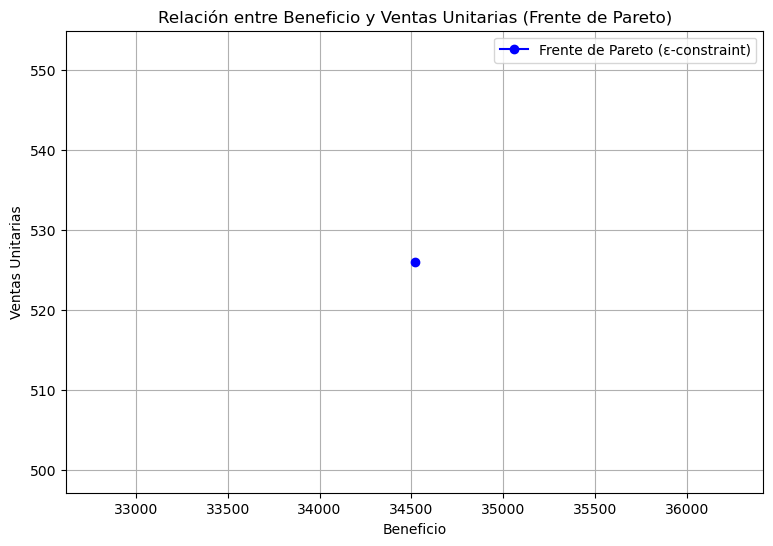

In [59]:
# Define the ventas_constraint if not already defined
if not hasattr(model, 'ventas_constraint'):
	model.ventas_constraint = Constraint(expr=ventas_unitarias(model) >= 0)

model.ventas_constraint.deactivate()  # Desactiva el objetivo de ventas
model.objetivo = Objective(expr=beneficio(model), sense=maximize)
result = opt.solve(model, tee=False)
beneficio_max = value(beneficio(model))
a_beneficio_max = value(model.a)
value_max_beneficio = ventas_unitarias(model)()

print(f"Máximo beneficio: {beneficio_max}")
print(f'A de beneficio máximo: {a_beneficio_max}')

plt.figure(figsize=(9, 6))
plt.plot(beneficio_max, value_max_beneficio, 'bo-', label='Frente de Pareto (ε-constraint)')
plt.title("Relación entre Beneficio y Ventas Unitarias (Frente de Pareto)")
plt.xlabel("Beneficio")
plt.ylabel("Ventas Unitarias")
plt.grid(True)
plt.legend()
plt.show()

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Máxima ventas unitaria: 916.3157932736842
a de Ventas unitarias: 6.925206757551527


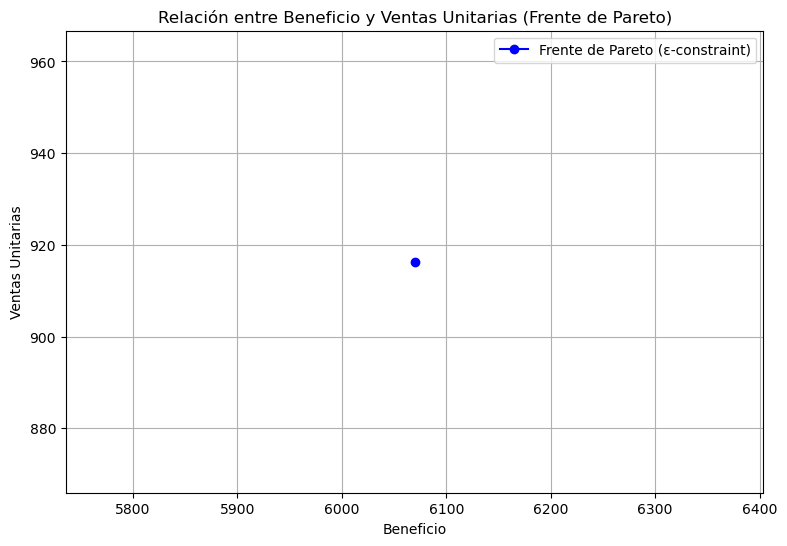

In [58]:

model.ventas_constraint.deactivate()  # Desactiva el objetivo de ventas
model.objetivo = Objective(expr=ventas_unitarias(model), sense=maximize)
result = opt.solve(model, tee=False)
beneficio_max = value(beneficio(model))
a_beneficio_max = value(model.a)
value_max_beneficio = ventas_unitarias(model)()

print(f"Máxima ventas unitaria: {value_max_beneficio}")
print(f"a de Ventas unitarias: {a_beneficio_max}")

plt.figure(figsize=(9, 6))
plt.plot(beneficio_max, value_max_beneficio, 'bo-', label='Frente de Pareto (ε-constraint)')
plt.title("Relación entre Beneficio y Ventas Unitarias (Frente de Pareto)")
plt.xlabel("Beneficio")
plt.ylabel("Ventas Unitarias")
plt.grid(True)
plt.legend()
plt.show()

### Parte III: Graficar la frontera de Pareto

Encuentra al menos 10 puntos de Pareto-óptimos y traza la frontera de Pareto entre los objetivos de maximizar el beneficio y maximizar el número de unidades vendidas.

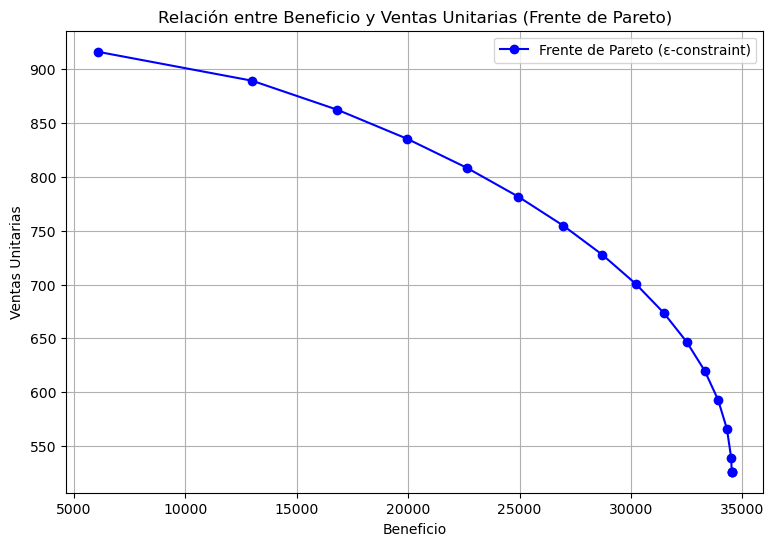

In [56]:
plt.figure(figsize=(9, 6))
plt.plot(soluciones_beneficio, soluciones_ventas, 'bo-', label='Frente de Pareto (ε-constraint)')
plt.title("Relación entre Beneficio y Ventas Unitarias (Frente de Pareto)")
plt.xlabel("Beneficio")
plt.ylabel("Ventas Unitarias")
plt.grid(True)
plt.legend()
plt.show()

Implementen el método de **$\epsilon$-constraint** para encontrar el **frente óptimo de Pareto** en un problema de optimización multiobjetivo. La idea detrás de este método es optimizar un objetivo principal mientras se aplica una restricción sobre el otro objetivo, permitiendo obtener soluciones óptimas que representen diferentes compromisos entre ambos objetivos (en este caso, maximizar el **beneficio** y maximizar las **ventas unitarias**).

### Explicación del Método $\epsilon$-Constraint

1. **Definición del Problema**:  
   El problema tiene dos objetivos conflictivos:
   - **Maximizar el beneficio** ($f_2(a)$).
   - **Maximizar las ventas unitarias** ($f_1(a)$).
   
   Como estos objetivos están en conflicto (aumentar el beneficio podría reducir las ventas y viceversa), necesitamos encontrar un conjunto de soluciones óptimas donde no se puede mejorar un objetivo sin empeorar el otro, es decir, el **frente de Pareto**.

2. **¿Qué es el método $\epsilon$-Constraint?**:  
   El método $\epsilon$-constraint optimiza uno de los objetivos (por ejemplo, el beneficio) mientras que el otro objetivo se convierte en una restricción limitada por un valor $\epsilon$.
   
   En el código, lo que se hace es:
   - Primero, se **maximiza el beneficio** bajo una restricción que lo limita a un porcentaje de su valor máximo posible.
   - Luego, se optimiza la función de **ventas unitarias** asegurando que el beneficio no disminuya por debajo del valor encontrado en la primera etapa.

3. **Cómo se calculan los valores $\epsilon$ (fronteras)**:  
   Los valores $\epsilon$ en este caso se calculan como un porcentaje de la diferencia entre el **valor máximo** y el **valor mínimo** del beneficio. Este valor $\epsilon$ establece el límite superior para el beneficio en cada iteración. Así es como se asegura que el beneficio no supere un porcentaje del beneficio máximo posible, permitiendo así maximizar las ventas unitarias bajo ese límite.

   La fórmula para establecer este límite es:
   $$
   \text{profit\_limit} = \text{profit\_max} - (\text{profit\_max} - \text{profit\_min}) \times w1
   $$
   Donde:
   - **profit\_max** es el valor máximo del beneficio.
   - **profit\_min** es el valor mínimo del beneficio.
   - **w1** es un peso que varía entre 0 y 1
4. **Iteración para encontrar soluciones de Pareto**:  
   El código genera múltiples soluciones cambiando el valor de **w1** en el rango de 0 a 1. Esto permite explorar diferentes compromisos entre el beneficio y las ventas unitarias:
   - Cuando **w1 = 0**, se permite el beneficio máximo posible.
   - Cuando **w1 = 1**, se reduce el beneficio al mínimo y se maximizan las ventas.
   
   Cada vez que el valor de **w1** cambia, el modelo se resuelve nuevamente para encontrar un nuevo compromiso óptimo entre beneficio y ventas, generando así una solución del frente de Pareto.

### Parte (d): Discusión

Supongamos que la empresa startup ahora decide que, aunque ambos objetivos son importantes, maximizar el número de unidades vendidas es más importante que maximizar el beneficio. ¿Qué sugerencias le darías a la empresa basándote en tus resultados de las partes (b) y (c)?

Dado que el objetivo principal de la empresa es maximizar el número de unidades vendidas por encima del beneficio, se recomienda elegir uno de los dos puntos de Pareto en la parte superior izquierda del primer gráfico. Estos puntos representan aproximadamente:

- **916 ventas unitarias** con un beneficio cercano a **5,000**.
- **890 ventas unitarias** con un beneficio de alrededor de **10,000**.

Ambos puntos maximizan las ventas unitarias, y al mismo tiempo permiten mantener un nivel aceptable de beneficio, aunque no sea el máximo posible. Seleccionar cualquiera de estos puntos le permitiría a la empresa priorizar su objetivo de volumen de ventas sin renunciar completamente a la rentabilidad. 